***
## notebook config

In [1]:
ON_COLAB = False
ASSESS = True

In [2]:
if ON_COLAB:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/drive', force_remount=True)
    
    !pip install --upgrade kaggle > /dev/null 2>&1
    !mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    
    !free -h
    
    !pip install --upgrade category_encoders > /dev/null 2>&1
    !pip install --upgrade tsforest > /dev/null 2>&1
    !pip install --upgrade lightgbm > /dev/null 2>&1
    !pip install --upgrade optuna > /dev/null 2>&1

In [3]:
if ON_COLAB:
    !kaggle datasets download -d mavillan/meli-2021 --force --unzip
    !ls -halt
    input_path = "./"
    print("input_path:", input_path)
    subs_path = "/content/drive/MyDrive/meli2021/subs"
    print("subs_path:", subs_path)
    results_path = "/content/drive/MyDrive/meli2021/results"
    print("results_path:", results_path)
else:
    input_path = "../data"
    print("input_path:", input_path)
    subs_path = "../subs"
    print("subs_path:", subs_path)
    results_path = "../results"
    print("results_path:", results_path)

input_path: ../data
subs_path: ../subs
results_path: ../results


In [4]:
SEED = 19
SUB_NBR = "13"

***

In [5]:
from copy import deepcopy
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from tqdm import tqdm
import yaml

import category_encoders as ce
import lightgbm as lgb
from tsforest.forecast import LightGBMForecaster

import sys
sys.path.append("../utils")
from memory import reduce_mem_usage
from metrics import RMSSE, ranked_probability_score, scoring_function, binarize_predictions
from inventory import InventoryDaysPredictor
from features import Featurador

np.random.seed(SEED)
pd.set_option('display.max_columns', None)

***
## loading data for assessment

In [6]:
if ASSESS:
    scales = pd.read_csv(f"{input_path}/scales.csv")
    skus_for_test = pd.read_csv(f"{input_path}/test_data.csv").sku.values
    skus_for_assess = pd.read_csv(f"{input_path}/skus_for_assess.csv").sku.values
    print("# skus test:", len(skus_for_test))
    print("# skus assess:", len(skus_for_assess))
    
    skus_for_assess = set(skus_for_assess) & set(skus_for_test)
    print("# skus assess & test:", len(skus_for_assess))

    dataset = (
        pd.read_parquet(f"{input_path}/train.parquet")
        .query("sku in @skus_for_assess")
        .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
        .sort_values(["sku","ds"])
        .reset_index(drop=True)
    )

# skus test: 551472
# skus assess: 496797
# skus assess & test: 421636


In [7]:
if ASSESS:
    raw = pd.read_parquet(f"{input_path}/train_data.parquet", columns=["sku", "date", "sold_quantity", "minutes_active"])
    metadata = pd.read_csv(f"{input_path}/metadata.csv", usecols=["sku","item_domain_id","site_id"])
    raw = pd.merge(raw, metadata, how="inner", on="sku")

    # compute q_mean and q_std features (w/o leakage)
    feat = Featurador(raw)
    feat.fit(left_limit="2021-02-01", right_limit="2021-03-01")
    dataset = feat.transform(dataset)

In [8]:
with open(f"../config/dist_hparams.yml", "r") as file:
    dist_config = yaml.load(file, Loader=yaml.FullLoader)
    file.close()
dist_config

{'beta': 0.5607622708084541,
 'corr_factor': 1.2025296178014329,
 'lambda1': 0.5476473565886333,
 'lambda2': 0.8678989339789255}

In [9]:
with open(f"../data/skus_assess_m2.yaml", "r") as file:
    skus_assess_m2 = yaml.load(file, Loader=yaml.FullLoader)
    print(len(skus_assess_m2))
    file.close()

272130


***
## model config

In [10]:
categorical_features = {
    "sku": ("y", ce.CatBoostEncoder, None),
    "currency": "default",
    "listing_type": "default",
    "shipping_logistic_type": "default",
    "shipping_payment": "default",
    "item_domain_id": "default",
    "item_id": ("y", ce.CatBoostEncoder, None),
    "site_id":"default",
    "product_id": ("y", ce.CatBoostEncoder, None),
    "product_family_id": ("y", ce.CatBoostEncoder, None),
}

exclude_features = ["fold","sold_quantity",]

model_params = {
    'objective':'tweedie',
    'tweedie_variance_power':1.6,
    'metric':'None',
    'num_iterations':1000,
    'max_bin': 63,
    'bin_construct_sample_cnt':20000000,
    'num_leaves': 2**8-1,
    'min_data_in_leaf': 2**8-1,
    'learning_rate': 0.02,
    'max_delta_step':1.,
    'feature_fraction':0.8,
    'bagging_fraction':0.8,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'max_cat_threshold': 64,
    'cat_l2': 50,
    'cat_smooth': 50,
    'boost_from_average': False,
    'force_row_wise': True,
    'deterministic':True,
    'seed':SEED,
}
time_features = [
    "week_day",
    "week_day_cos",
    "week_day_sin",
    "month_progress",
]
model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "exclude_features":exclude_features,
    "categorical_features":categorical_features,
    "ts_uid_columns":["sku",],
    "lags": [1,],
    "window_functions":{
        "mean":   (None, [1,], [3,5,7,]),
        "std":    (None, [1,], [3,5,7]),
    },
}

***
## model training: assessment

------------------------------------------------------------------------------------------
Preparing model for site: MLA
Mem. usage decreased to 106.31 Mb (51.6% reduction)
Mem. usage decreased to 111.11 Mb (51.6% reduction)
Elapsed time for processing features: 0.5128537853558858 min.
[LightGBM] [Info] Total Bins 2614
[LightGBM] [Info] Number of data points in the train set: 1061623, number of used features: 23
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.821527
[100]	valid_0's rmsse: 0.778575
[150]	valid_0's rmsse: 0.774638
Early stopping, best iteration is:
[143]	valid_0's rmsse: 0.774595


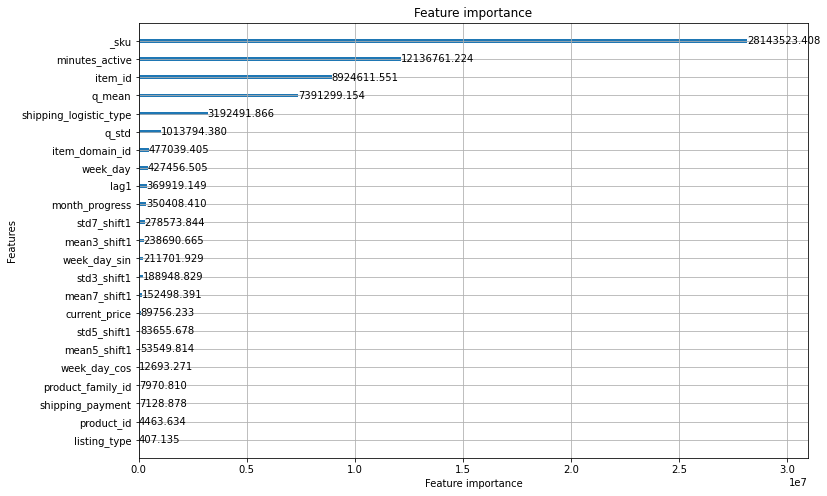

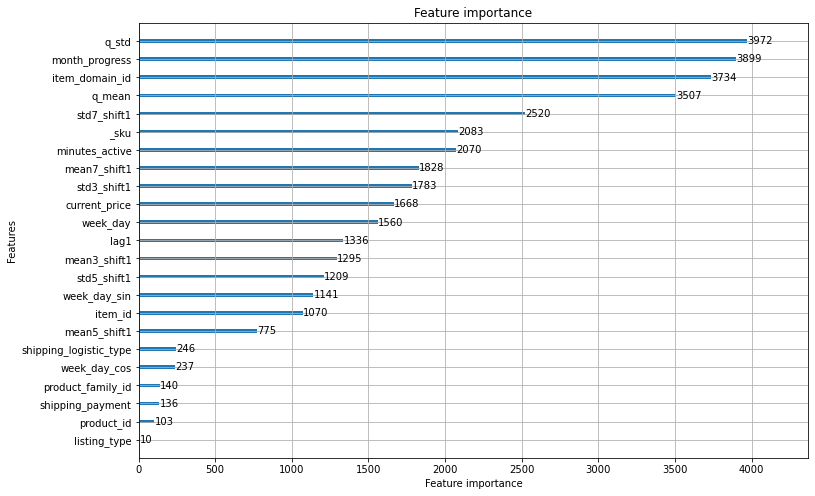

Elapsed time for training the model: 0.7897639791170756 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLB
Mem. usage decreased to 616.87 Mb (51.6% reduction)
Mem. usage decreased to 642.45 Mb (51.6% reduction)
Elapsed time for processing features: 3.528247598807017 min.
[LightGBM] [Info] Total Bins 3233
[LightGBM] [Info] Number of data points in the train set: 6160383, number of used features: 23
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.864808
[100]	valid_0's rmsse: 0.814507
[150]	valid_0's rmsse: 0.807958
Early stopping, best iteration is:
[158]	valid_0's rmsse: 0.807755


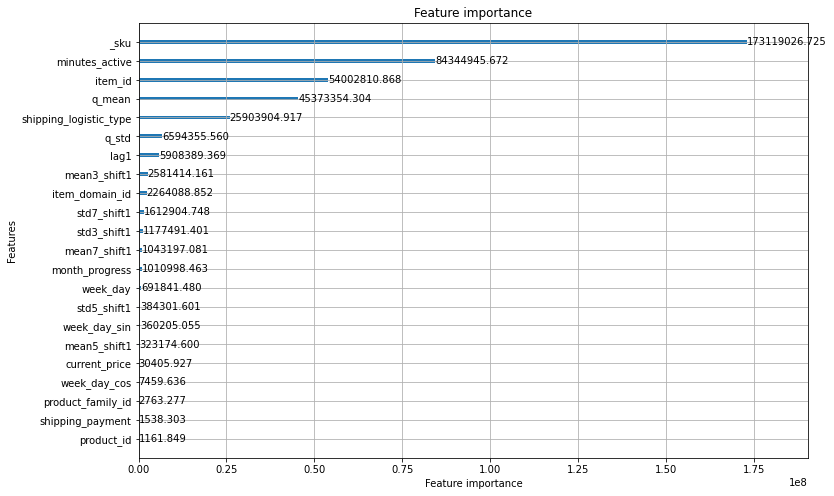

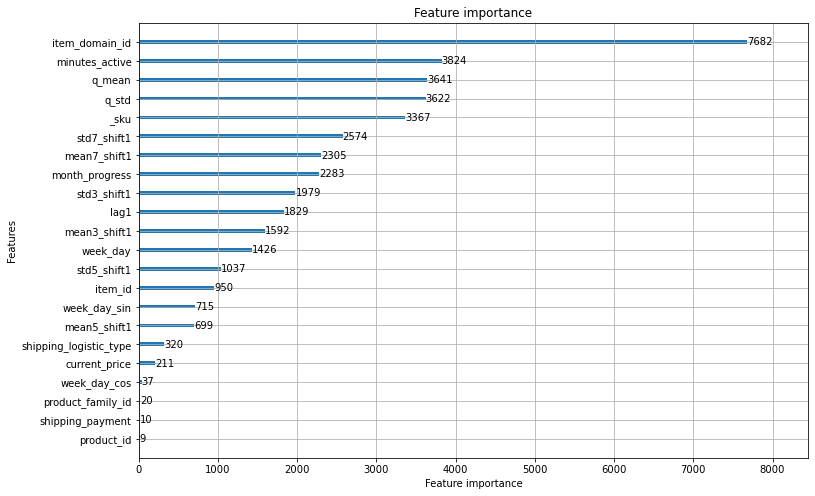

Elapsed time for training the model: 4.359566434224447 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLM
Mem. usage decreased to 490.52 Mb (51.6% reduction)
Mem. usage decreased to 513.06 Mb (51.6% reduction)
Elapsed time for processing features: 5.692958637078603 min.
[LightGBM] [Info] Total Bins 3117
[LightGBM] [Info] Number of data points in the train set: 4898512, number of used features: 23
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.823321
[100]	valid_0's rmsse: 0.77478
[150]	valid_0's rmsse: 0.769339
Early stopping, best iteration is:
[158]	valid_0's rmsse: 0.769205


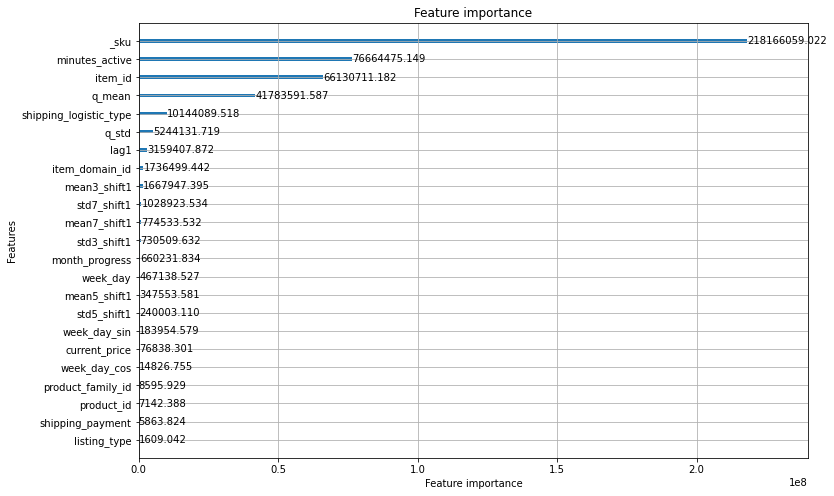

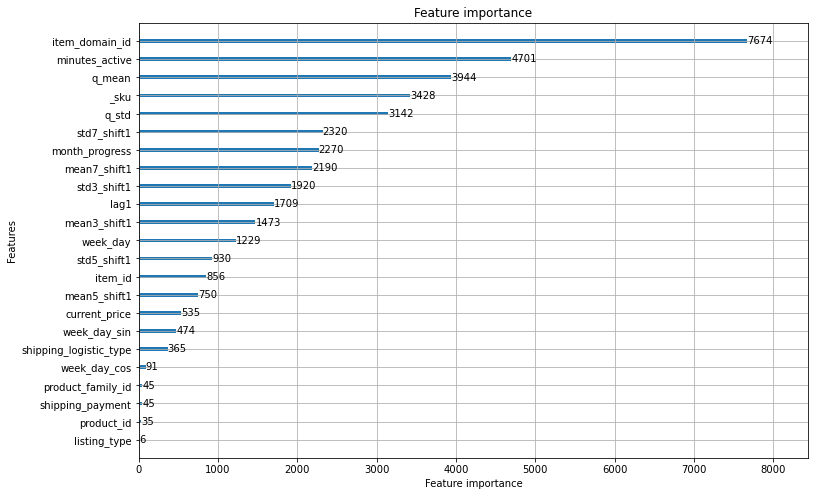

Elapsed time for training the model: 5.685000499089559 min.


{'rmsse_MLA': 0.77459502333038,
 'rmsse_MLB': 0.8077550969278491,
 'rmsse_MLM': 0.7692048414926829,
 'rmsse_AVG': 0.7838516539169706}

In [11]:
if ASSESS:
    models_by_site = list()
    sites = ["MLA","MLB","MLM"]

    for site in sites:
        print("-"*90)
        print(f"Preparing model for site: {site}")

        tic = time.time()
        train_data = dataset.query("site_id == @site").reset_index(drop=True)
        valid_idx = train_data.query("ds > '2021-03-01'").index

        model = LightGBMForecaster(**model_kwargs)
        model.prepare_features(train_data, valid_idx)
        model.train_features = reduce_mem_usage(model.train_features, verbose=True)
        model.valid_features = reduce_mem_usage(model.valid_features, verbose=True)
        gc.collect()
        tac = time.time()
        print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

        tic = time.time()
        evaluator = RMSSE(train_data.loc[valid_idx, ["sku","y"]], scales)
        model.fit(fit_kwargs={"verbose_eval":50, "feval":evaluator.evaluate})
        lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="gain")
        lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="split")
        plt.show()
        models_by_site.append(model)
        tac = time.time()
        print(f"Elapsed time for training the model: {(tac-tic)/60} min.")

    errors = list()
    sites = ["MLA","MLB","MLM"]
    for site,model in zip(sites,models_by_site):
        error = model.model.model.best_score["valid_0"]["rmsse"]
        errors.append(error)
    result = {
        "rmsse_MLA":errors[0], 
        "rmsse_MLB":errors[1],
        "rmsse_MLM":errors[2],
        "rmsse_AVG":np.mean(errors),
    }
    display(result)

In [12]:
%%time
if ASSESS:
    all_preds = list()
    for site,model in zip(sites,models_by_site):
        print("Preds for site:", site)
        preds = model.predict(dataset.query("site_id==@site & ds>'2021-03-01'"), recursive=True)
        all_preds.append(preds)
    oof = pd.concat(all_preds, axis=0, ignore_index=True)

Preds for site: MLA
Preds for site: MLB
Preds for site: MLM
CPU times: user 14min 4s, sys: 1min 7s, total: 15min 11s
Wall time: 30min 55s


In [13]:
if ASSESS:
    mrg = pd.merge(oof, dataset.loc[:,["ds","sku","site_id","y"]], how="inner", on=["ds","sku"])
    mrg["sq_error"] = mrg.eval("(y-y_pred)**2")
    valid_errors = np.sqrt(mrg.groupby(["sku","site_id"])["sq_error"].mean()).reset_index(name="rmse")
    valid_errors = pd.merge(valid_errors, scales, how="inner", on="sku")
    valid_errors["rmsse"] = valid_errors.eval("rmse/scale")
    display(valid_errors.groupby("site_id")["rmsse"].mean())

site_id
MLA    0.781361
MLB    0.820192
MLM    0.783640
Name: rmsse, dtype: float64

In [14]:
if ASSESS:
    oof.to_csv(f"{results_path}/oof_preds_lgbm-m1.csv", index=False)

***
## Assessment of invetory days prediction

In [15]:
if ASSESS:
    if "oof" not in locals():
        oof = pd.read_csv("../results/oof_preds_lgbm-m1.csv")
        
    predictor = InventoryDaysPredictor(dataset.query("ds <= '2021-03-01'"))
    predictor.fit(oof)

100%|██████████| 421636/421636 [00:55<00:00, 7568.03it/s]


In [16]:
if ASSESS:
    valid = (
        pd.read_csv(f"{input_path}/validation_realstock.csv")
        .query("sku in @skus_for_assess")
        .reset_index(drop=True)
    )

    preds = list()
    for sku,df in tqdm(valid.groupby("sku")):
        preds.append(predictor.predict(sku, df.target_stock.values[0])[0])
        
    valid["days_to_stockout"] = np.asarray(preds)

100%|██████████| 421636/421636 [00:52<00:00, 7959.78it/s]


RMSE (mean):  8.500691608636691
MAE (mean):  5.974666498404377
MAE (median):  3.878696762659697


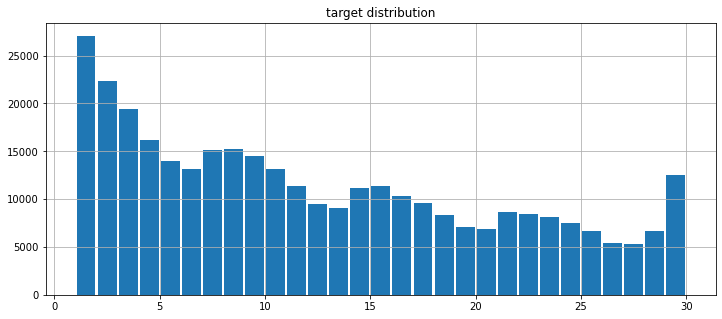

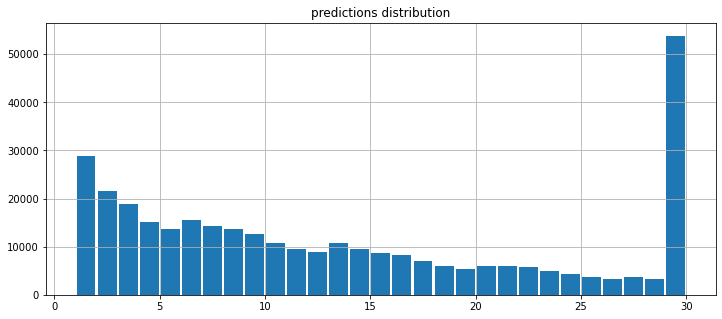

In [17]:
if ASSESS:
    print("RMSE (mean): ", np.sqrt(valid.query("inventory_days <= 31").eval("(days_to_stockout - inventory_days)**2").mean()) )
    print("MAE (mean): ",  valid.query("inventory_days <= 31").eval("abs(days_to_stockout - inventory_days)").mean() )
    print("MAE (median): ", valid.query("inventory_days <= 31").eval("abs(days_to_stockout - inventory_days)").median() )
    
    plt.figure(figsize=(12,5))
    plt.hist(valid.query("inventory_days <= 31").inventory_days, bins=np.arange(1,31,1), rwidth=0.9)
    plt.title(f"target distribution")
    plt.grid()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.hist(valid.query("inventory_days <= 31").days_to_stockout, bins=np.arange(1,31,1), rwidth=0.9)
    plt.title(f"predictions distribution")
    plt.grid()
    plt.show()

RMSE (mean):  7.377399612393022
MAE (mean):  5.089704710495643
MAE (median):  3.2317173456191775


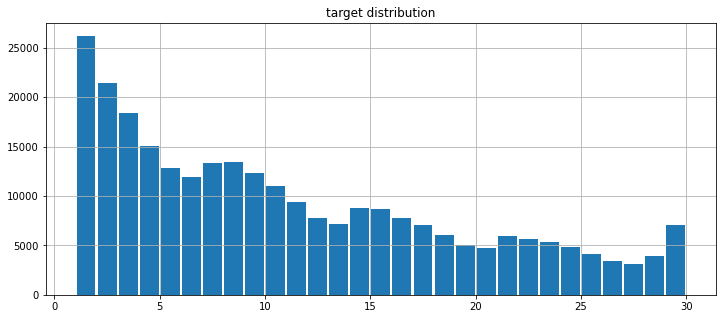

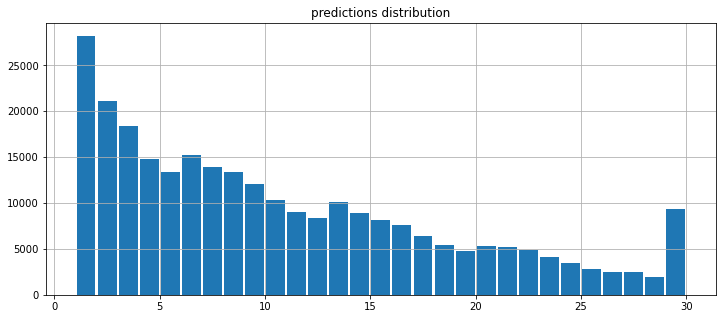

In [18]:
if ASSESS:
    print("RMSE (mean): ", np.sqrt(valid.query("sku in @skus_assess_m2").eval("(days_to_stockout - inventory_days)**2").mean()) )
    print("MAE (mean): ",  valid.query("sku in @skus_assess_m2").eval("abs(days_to_stockout - inventory_days)").mean() )
    print("MAE (median): ", valid.query("sku in @skus_assess_m2").eval("abs(days_to_stockout - inventory_days)").median() )
    
    plt.figure(figsize=(12,5))
    plt.hist(valid.query("sku in @skus_assess_m2").inventory_days, bins=np.arange(1,31,1), rwidth=0.9)
    plt.title(f"target distribution")
    plt.grid()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.hist(valid.query("sku in @skus_assess_m2").days_to_stockout, bins=np.arange(1,31,1), rwidth=0.9)
    plt.title(f"predictions distribution")
    plt.grid()
    plt.show()

***
## Assessment of RPS

In [19]:
# dist config from sub04
dist_config = {
    "beta": 0.634505,
    "lambda1": 0.458712,
    "lambda2": 0.967726,
}

In [20]:
if ASSESS:
    valid_files = [fn for fn in glob(f"{input_path}/validation_*.csv") if "seed2.csv" not in fn]
    results = list()

    for files in valid_files:
        valid = (
            pd.read_csv(files)
            .query("sku in @skus_for_assess")
            .query("inventory_days <= 30")
            .reset_index(drop=True)
        )
        valid["inventory_days"] = valid["inventory_days"].astype(int)
        
        preds_proba = list()
        for sku,df in tqdm(valid.groupby("sku")):
            preds_proba.append(predictor.predict_proba(
                sku, 
                stock=df.target_stock.values[0],
                dist_kwargs={"beta":dist_config["beta"]},
                lambda1=dist_config["lambda1"], 
                lambda2=dist_config["lambda2"],
            ))
        preds_proba = np.array(preds_proba)

        rps = scoring_function(valid.inventory_days.values, preds_proba)
        results.append({"file":files.split("/")[-1].split(".")[0], "rps":rps})
        print({"file":files.split("/")[-1].split(".")[0], "rps":rps})

100%|██████████| 421636/421636 [01:59<00:00, 3533.76it/s]


{'file': 'validation_seed19', 'rps': 3.921238320369127}


100%|██████████| 421636/421636 [02:00<00:00, 3500.96it/s]


{'file': 'validation_seed23', 'rps': 3.9215951517577152}


100%|██████████| 334227/334227 [01:34<00:00, 3525.73it/s]


{'file': 'validation_realstock', 'rps': 3.5691358543511322}


100%|██████████| 421636/421636 [01:59<00:00, 3516.06it/s]


{'file': 'validation_seed17', 'rps': 3.92284283493727}


In [21]:
if ASSESS:
    display(pd.DataFrame(results))
    
    # cleanup ram
    del models_by_site
    gc.collect()

,file,rps
0,validation_seed19,3.921238
1,validation_seed23,3.921595
2,validation_realstock,3.569136
3,validation_seed17,3.922843


***
## model training

In [22]:
unpredictable = pd.read_csv(f"{input_path}/unpredictable.csv")
skus_for_test = pd.read_csv(f"{input_path}/test_data.csv").sku.values

dataset = (
    pd.read_parquet(f"{input_path}/train.parquet")
    .query("sku not in @unpredictable.sku")
    .query("sku in @skus_for_test")
    .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
    .sort_values(["sku","ds"])
    .reset_index(drop=True)
)
print("nrows:", len(dataset)/1e6)
print("nskus:", dataset.sku.nunique())

nrows: 30.218544
nskus: 526189


In [23]:
test = (
    pd.read_parquet(f"{input_path}/test.parquet")
    .query("sku not in @unpredictable.sku")
    .rename({"date":"ds",}, axis=1,)
    .sort_values(["sku","ds"])
    .reset_index(drop=True)
)
print("nrows:", len(test)/1e6)
print("nskus:", test.sku.nunique())

nrows: 15.78567
nskus: 526189


In [24]:
# compute q_mean and q_std features (w/o leakage)
feat = Featurador(raw)
feat.fit(left_limit="2021-02-01", right_limit="2021-03-31")
dataset = feat.transform(dataset)
test = feat.transform(test)

------------------------------------------------------------------------------------------
Preparing model for site: MLA
Mem. usage decreased to 262.55 Mb (51.6% reduction)
Elapsed time for processing features: 0.7490304986635844 min.
[LightGBM] [Info] Total Bins 2680
[LightGBM] [Info] Number of data points in the train set: 2621983, number of used features: 23


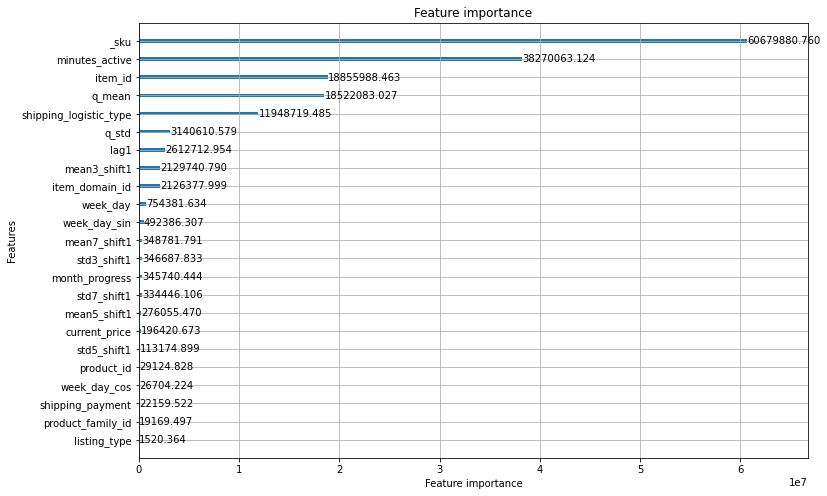

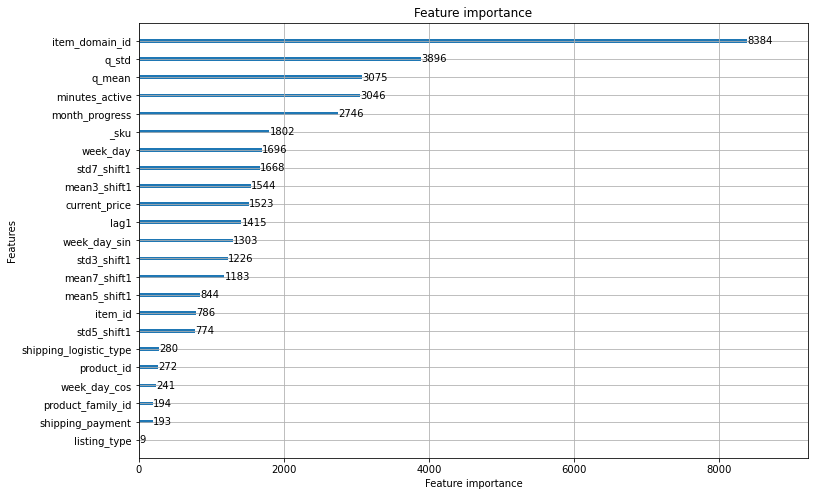

Elapsed time for training the model: 0.3800031463305155 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLB
Mem. usage decreased to 1579.24 Mb (50.7% reduction)
Elapsed time for processing features: 4.292041265964508 min.
[LightGBM] [Info] Total Bins 3288
[LightGBM] [Info] Number of data points in the train set: 15476240, number of used features: 23


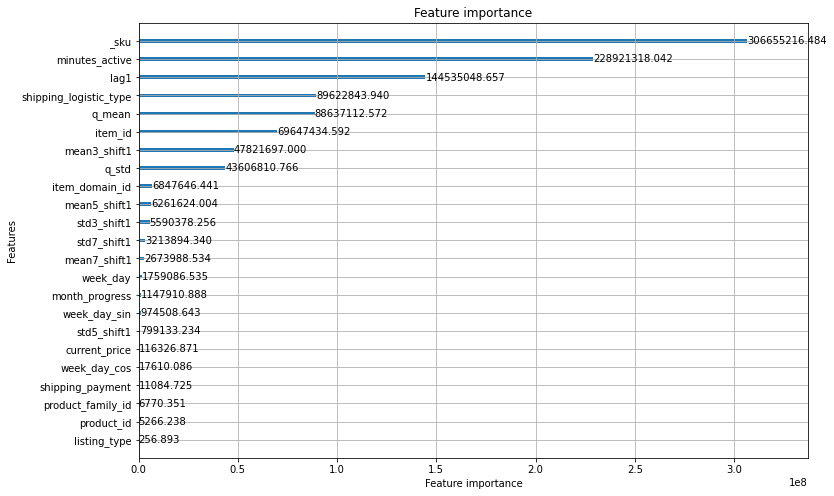

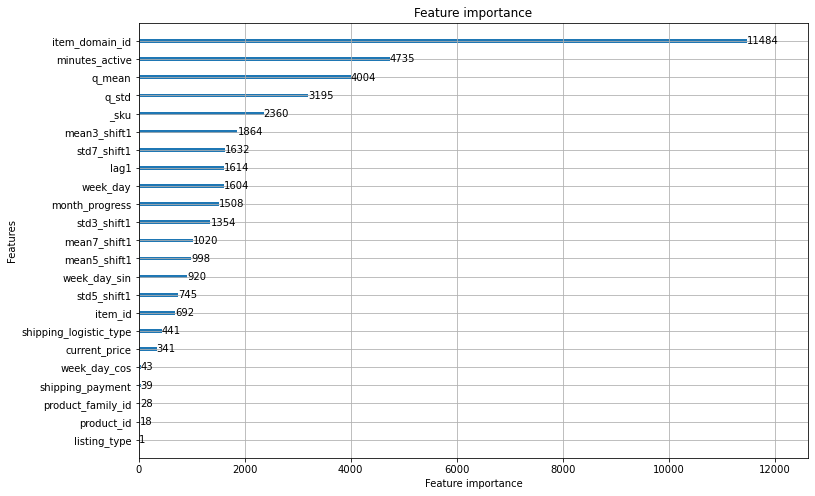

Elapsed time for training the model: 2.237206284205119 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLM
Mem. usage decreased to 1213.68 Mb (51.6% reduction)
Elapsed time for processing features: 3.716215634346008 min.
[LightGBM] [Info] Total Bins 3161
[LightGBM] [Info] Number of data points in the train set: 12120321, number of used features: 23


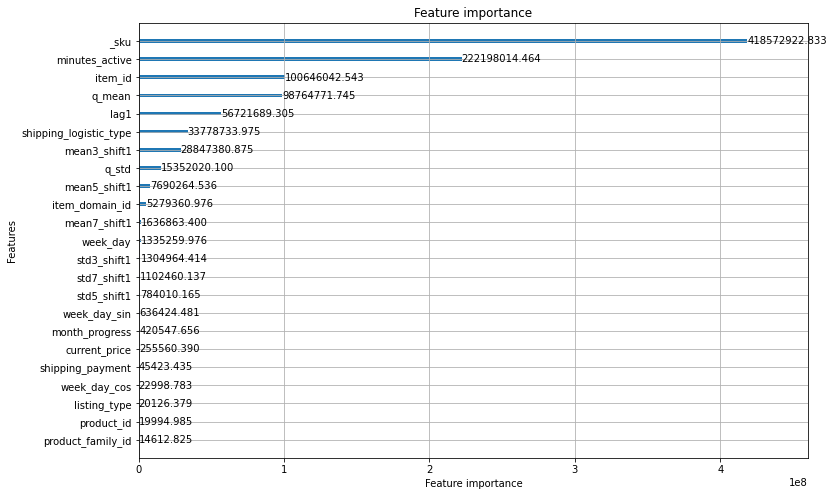

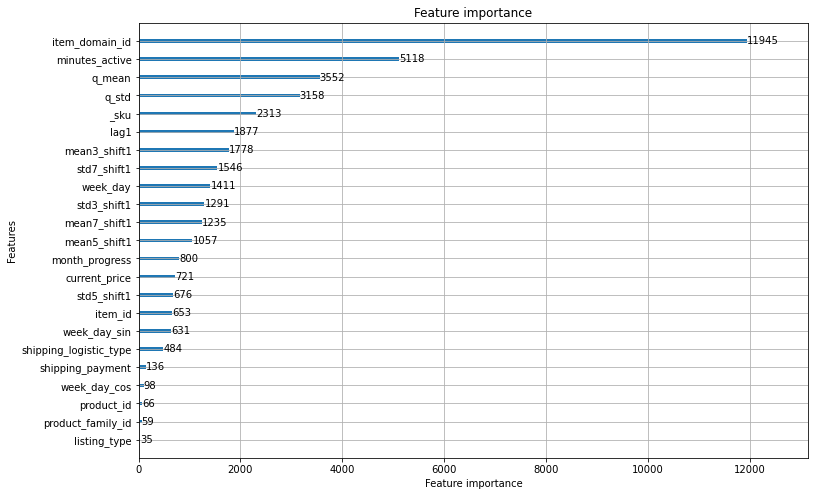

Elapsed time for training the model: 1.851231817404429 min.


In [25]:
models_by_site = list()
sites = [
    "MLA",
    "MLB",
    "MLM",
]
num_iterations = {
    "MLA": 150,
    "MLB": 160,
    "MLM": 160,
}

for site in sites:
    print("-"*90)
    print(f"Preparing model for site: {site}")

    tic = time.time()
    train_data = dataset.query("site_id == @site").reset_index(drop=True)
    
    _model_kwargs = dict(model_kwargs)
    _model_kwargs["model_params"]["num_iterations"] = num_iterations[site]

    model = LightGBMForecaster(**_model_kwargs)
    model.prepare_features(train_data)
    model.train_features = reduce_mem_usage(model.train_features, verbose=True)
    gc.collect()
    tac = time.time()
    print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

    tic = time.time()
    model.fit()
    lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="gain")
    lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="split")
    plt.show()
    models_by_site.append(model)
    tac = time.time()
    print(f"Elapsed time for training the model: {(tac-tic)/60} min.")


In [26]:
preds_by_site = list()

for site,model in tqdm(zip(sites,models_by_site)):
    preds = model.predict(test.query("site_id == @site"), recursive=True)
    preds_by_site.append(preds)

3it [39:54, 798.21s/it]


In [27]:
predictions = pd.concat(preds_by_site, ignore_index=True)
predictions.to_csv(f"../results/preds_m1_lgbm_sub{SUB_NBR}.csv", index=False)

In [28]:
predictor = InventoryDaysPredictor(dataset)
predictor.fit(predictions)

100%|██████████| 526189/526189 [01:09<00:00, 7609.28it/s]


100%|██████████| 526189/526189 [01:04<00:00, 8197.87it/s]


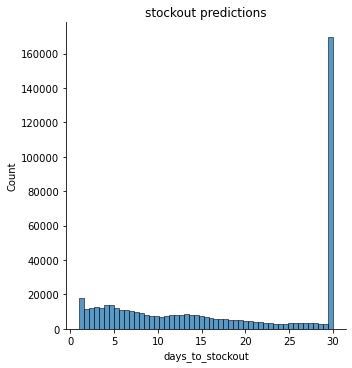

In [29]:
stockout_preds = list()
groups = (
    test[["sku","target_stock"]]
    .drop_duplicates()
    .groupby("sku")
)

for sku,df in tqdm(groups):
    stockout_preds.append(predictor.predict(sku, df.target_stock.values[0])[0])
stockout_preds = pd.DataFrame(stockout_preds, columns=["days_to_stockout"])

sns.displot(stockout_preds.days_to_stockout)
plt.title("stockout predictions")
plt.show()

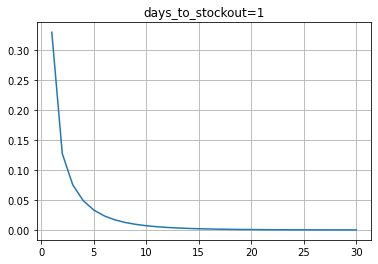

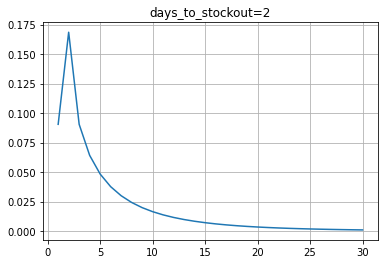

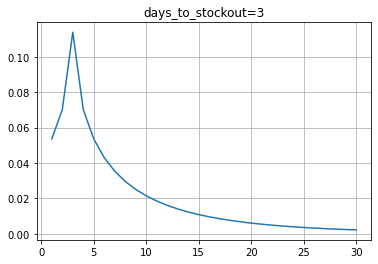

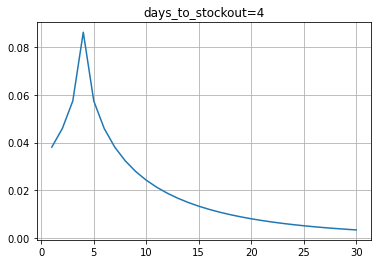

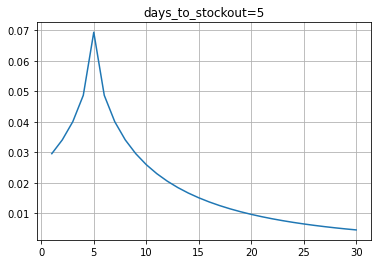

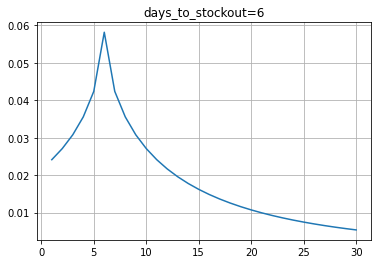

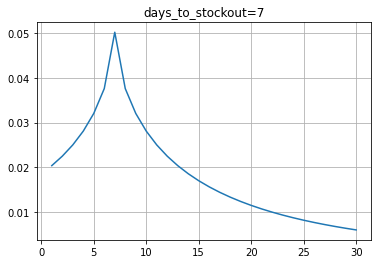

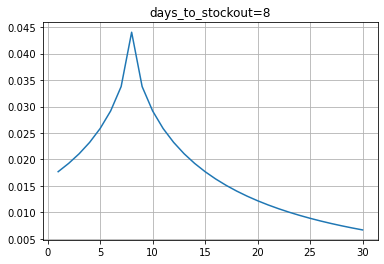

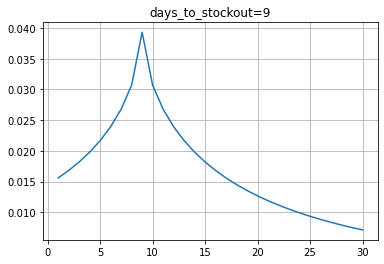

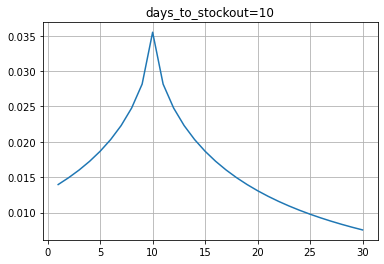

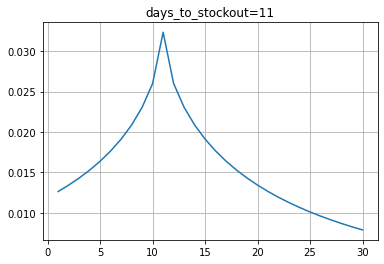

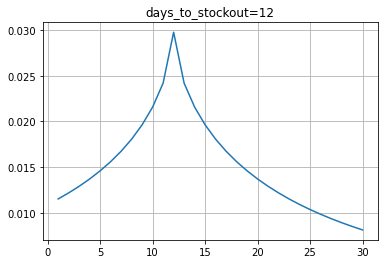

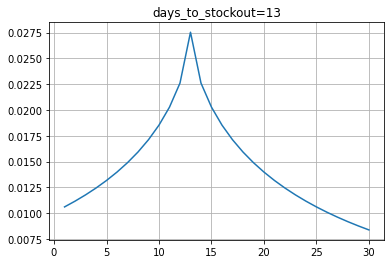

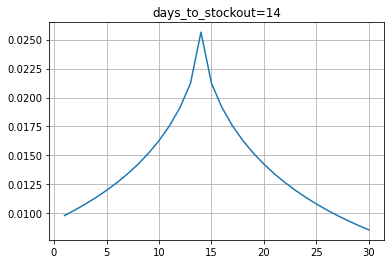

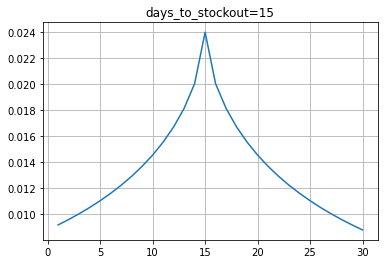

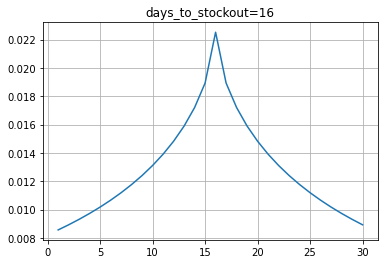

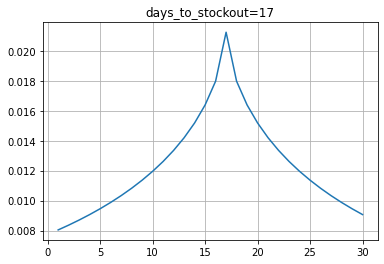

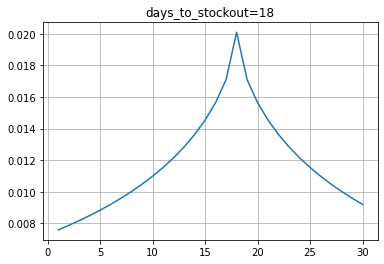

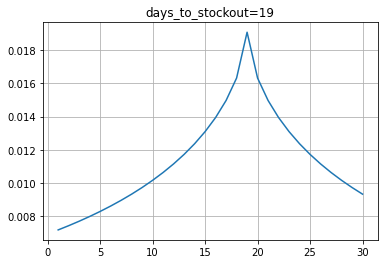

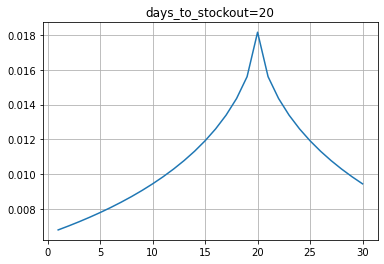

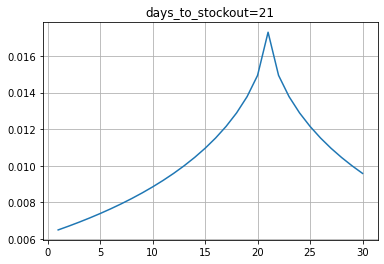

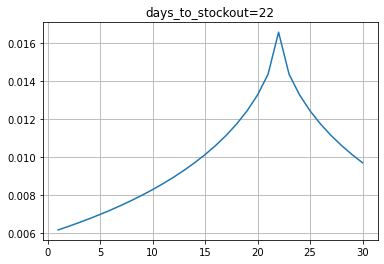

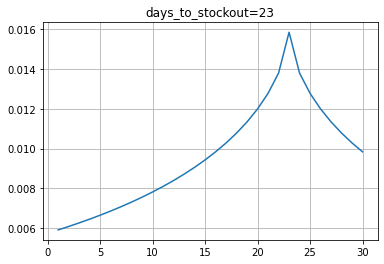

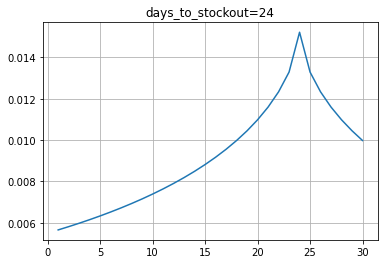

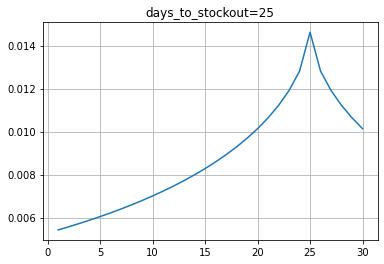

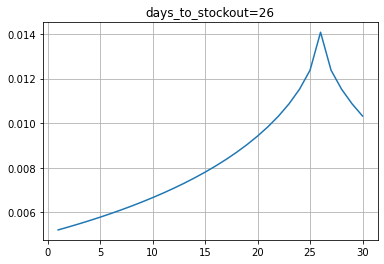

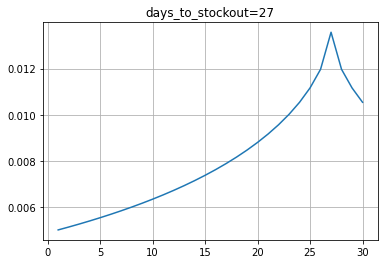

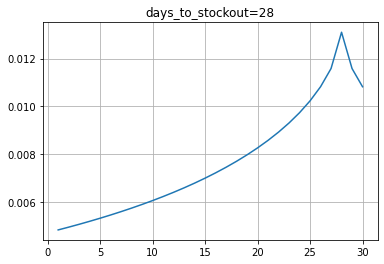

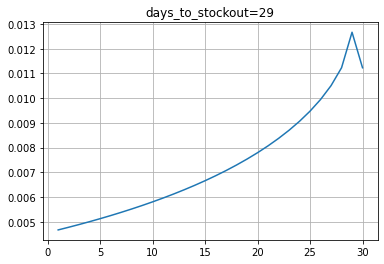

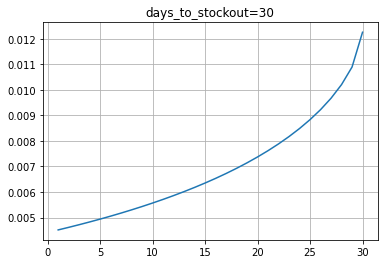

In [30]:
std_days = np.mean(np.asarray(list(predictor.parameters["std"].values())) / np.asarray(list(predictor.parameters["mean"].values())))

for days_to_stockout in range(1,31):
    scale = std_days * (dist_config["lambda1"]*(days_to_stockout**dist_config["lambda2"]))
    days = np.arange(1,31)
    probs = stats.gennorm.pdf(days, loc=days_to_stockout, scale=scale, beta=dist_config["beta"])
    
    plt.plot(days, probs)
    plt.grid()
    plt.title(f"days_to_stockout={days_to_stockout}")
    plt.show()

In [31]:
skus = list()
preds_proba = list()
groups = (
    test[["sku","target_stock"]]
    .drop_duplicates()
    .groupby("sku")
)

for sku,df in tqdm(groups):
    skus.append(sku)
    preds_proba.append(predictor.predict_proba(
        sku, 
        stock=df.target_stock.values[0],
        dist_kwargs={"beta":dist_config["beta"]},
        lambda1=dist_config["lambda1"], 
        lambda2=dist_config["lambda2"],
    ))
preds_proba = np.array(preds_proba)
preds_proba = pd.DataFrame(preds_proba, index=skus)

100%|██████████| 526189/526189 [02:42<00:00, 3245.89it/s]


In [32]:
unpreds_proba = np.ones((len(unpredictable),30)) / 30
unpreds_proba = pd.DataFrame(unpreds_proba, index=unpredictable.sku.values)

preds_proba_mrg = pd.concat([preds_proba, unpreds_proba])
preds_proba_mrg

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.073290,0.090137,0.129111,0.090495,0.073516,0.061950,0.053265,0.046414,0.040842,0.036214,0.032308,0.028971,0.026093,0.023589,0.021396,0.019463,0.017752,0.016230,0.014870,0.013652,0.012556,0.011567,0.010673,0.009863,0.009126,0.008455,0.007843,0.007284,0.006772,0.006302
1,0.020942,0.021442,0.021961,0.022500,0.023060,0.023643,0.024249,0.024882,0.025542,0.026231,0.026952,0.027708,0.028501,0.029335,0.030213,0.031140,0.032122,0.033163,0.034273,0.035459,0.036732,0.038107,0.039602,0.041241,0.043057,0.045102,0.047458,0.050274,0.053916,0.061192
2,0.025573,0.025934,0.026305,0.026686,0.027078,0.027482,0.027898,0.028328,0.028771,0.029229,0.029704,0.030195,0.030705,0.031235,0.031786,0.032362,0.032963,0.033593,0.034256,0.034954,0.035694,0.036481,0.037323,0.038232,0.039222,0.040317,0.041554,0.043000,0.044822,0.048319
3,0.027651,0.029376,0.031290,0.033435,0.035863,0.038653,0.041924,0.045882,0.050941,0.058340,0.059383,0.051548,0.046335,0.042290,0.038961,0.036128,0.033667,0.031497,0.029561,0.027819,0.026239,0.024800,0.023481,0.022267,0.021147,0.020108,0.019143,0.018245,0.017405,0.016620
5,0.020128,0.020657,0.021208,0.021782,0.022381,0.023007,0.023662,0.024348,0.025068,0.025825,0.026622,0.027462,0.028351,0.029294,0.030295,0.031364,0.032508,0.033738,0.035070,0.036519,0.038111,0.039879,0.041872,0.044171,0.046922,0.050473,0.056838,0.050854,0.047197,0.044394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393191,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
262125,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
393209,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
131068,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333


***
## generate submission

In [33]:
test = pd.read_csv(f"{input_path}/test_data.csv")
preds_proba_mrg = preds_proba_mrg.loc[test.sku.values,:].copy()

In [34]:
assert preds_proba_mrg.isna().sum(axis=1).sum() == 0
assert np.allclose(preds_proba_mrg.sum(axis=1).values, 1, atol=1e-16)
assert preds_proba_mrg.max(axis=1).max() < 1

In [35]:
(preds_proba_mrg
 .round(4)
 .to_csv(f"{subs_path}/sub{SUB_NBR}.csv.gz", header=False, index=False, compression="gzip")
)

***